# Annotated visualisations of longevity abstracts for AIIM publication - keyphrases

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# config
N_GRAM_LEN = 3

## Load data

In [3]:
import pandas as pd

df = pd.read_pickle('data/pubmed_longevity.pkl')
len_before = len(df)

df = df[df["abstract"].str.len() >= 100]
f"Dokument kept: {len(df)}/{len_before}"

'Dokument kept: 16778/16791'

## Preprocess and compute embeddings

In [4]:
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH
from textsemantics import specific_words


nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]

        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
    return preprocessed


abstracts = list(df['abstract'])
tokens_list = preprocess(abstracts)
doc_embs, word_embs, _, _ = specific_words.prepare_embeddings(tokens_list, 'en')

## Compute t-SNE embedding

In [5]:
%%time
from openTSNE import TSNE

tsne = TSNE(
    perplexity=500,
    initialization="pca",
    metric="cosine",
    n_jobs=2,
    random_state=0,
)

embedding_ = tsne.fit(doc_embs)

CPU times: user 8min 41s, sys: 5.86 s, total: 8min 47s
Wall time: 4min 34s


## Fucntion for clustering and visualisation

In [6]:
from orangecontrib.text.stats import hypergeom_p_values
from sklearn.feature_extraction.text import CountVectorizer
from Orange.statistics.util import FDR
import matplotlib.patheffects as path_effects
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter


CB_color_cycle = [
    '#377eb8', '#ff7f00', '#4daf4a',
    '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00'
]


def take_first_n(kws, n):
    """ 
    Take first n without duplications which are present because of normaliztion
    in YAKE    
    """
    selected = []
    for kw in kws:
        if len(selected) >= n:
            break
        if kw not in selected:
            selected.append(kw)
    assert len(selected) <= n
    return selected
    

def hypergeom_clusters(points, labels, keywords, ax):
    num_kw = 20
    clusters = []
    lengths = []
    cl_labels = list(set(labels) - {-1})
    
    # gather keywords in list
    for i, cluster in enumerate(cl_labels):
        cluster_idx = np.where(labels == cluster)[0]
        clis = set(cluster_idx)
        all_kws = [
            take_first_n(kws, num_kw) for i, kws in enumerate(keywords) if i in clis
        ]
        lengths.append(len(all_kws))
        clusters += all_kws
    
    # count appearances
    def dummy(doc):
        return doc
    cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
    x = cv.fit_transform(clusters)
    features = np.array(cv.get_feature_names_out())
    
    start = 0
    for i, ll in enumerate(lengths):
        # find words that should be specific for a group with hypergeom test
        selected = x[start:start+ll]
        p_values = hypergeom_p_values(x, selected)
        fdr = FDR(p_values)
        assert len(features) == len(fdr)
        bellow_threshold = set(features[np.array(fdr) < 0.05].tolist())
        print(i, len(bellow_threshold))
        
        # use counts as measure but select only words which p-vales pass the threshold
        c = Counter([k for kws in clusters[start:start+ll] for k in kws])
        selected = []
        for el, _ in c.most_common():
            if len(selected) >= 5:
                break
            if el in bellow_threshold:
                selected.append(el)     
        
        start += ll 
        # plot
        cluster_idx = np.where(labels == cl_labels[i])[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
        ann = "\n".join(selected) + f'\n\n{i+1}'
        ax.text(centroid[0], centroid[1], ann,                 
                fontdict={'fontweight': 'bold', 'fontsize': 'xx-large'},
                va='center', ha='center')

        
def create_plot(kw, title='', label_method=hypergeom_clusters, sublinear_tf=False):

    estimator = GaussianMixture(n_components=8,
                covariance_type='full', max_iter=20, random_state=0)

    estimator.fit(embedding_)
    _, ax = plt.subplots(figsize=(12, 12))
    plt.style.use('seaborn')

    probs = estimator.predict_proba(embedding_)
    labels = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    labels[max_probs < 0.6] = -1

    n_noise = list(labels).count(-1)
    #palette = sns.color_palette('colorblind', 8)
    palette = CB_color_cycle
    cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in labels]
    s = [36 if l > -1 else 9 for l in labels]
    plt.scatter(embedding_[:, 0], embedding_[:, 1], c=cs,
                alpha=0.3, s=s);

    desc = label_method(embedding_, labels, kw, ax)

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_facecolor("white")

    return desc

## Visualisation with TF-IDF keywords

In [7]:
%%time 
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf_keywords(tokens):
    joined_texts = [" ".join(tokens) for tokens in tokens]
    vectorizer = TfidfVectorizer(ngram_range=(1, N_GRAM_LEN))
    X = vectorizer.fit_transform(joined_texts)
    words = vectorizer.get_feature_names_out()

    keywords = []
    for row in X:
        features = [(words[i], row[0, i]) for i in row.nonzero()[1]]
        keywords.append(sorted(features, key=lambda tup: tup[1], reverse=True))
    return keywords


tfidf_kw = tfidf_keywords(tokens_list)
tfidf_kw = [[x for x, _ in wds] for wds in tfidf_kw]

CPU times: user 2min 35s, sys: 1.23 s, total: 2min 36s
Wall time: 2min 36s


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 114
1 223
2 450
3 145
4 294
5 208
6 226
7 380


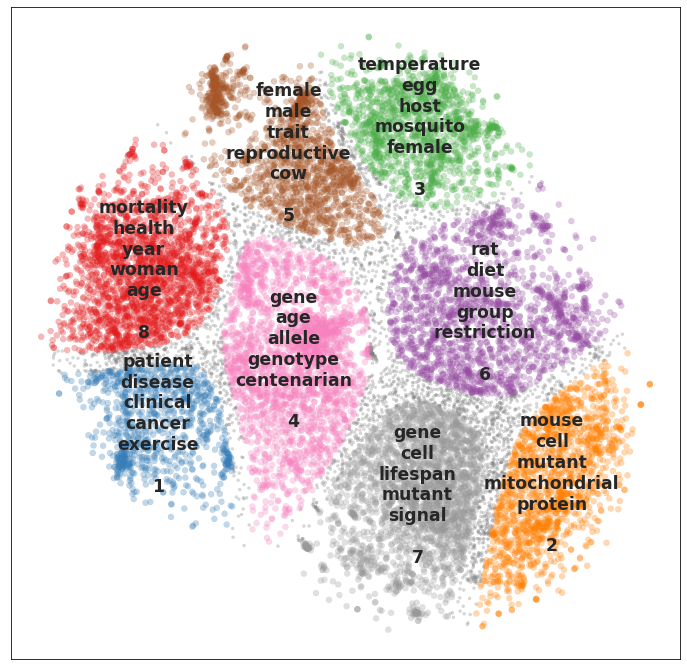

In [8]:
tfidf_desc = create_plot(tfidf_kw,  title='tf-idf - hyper', label_method=hypergeom_clusters)

## Visulaisation with YAKE keyowrds

In [9]:
%%time 
import yake

custom_kw_extractor = yake.KeywordExtractor(lan="en", n=3, top=20)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [" ".join(lemmatizer.lemmatize(w) for w in x.split()) for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 27min 54s, sys: 7.01 s, total: 28min 1s
Wall time: 27min 52s


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 109
1 233
2 461
3 162
4 290
5 200
6 339
7 454


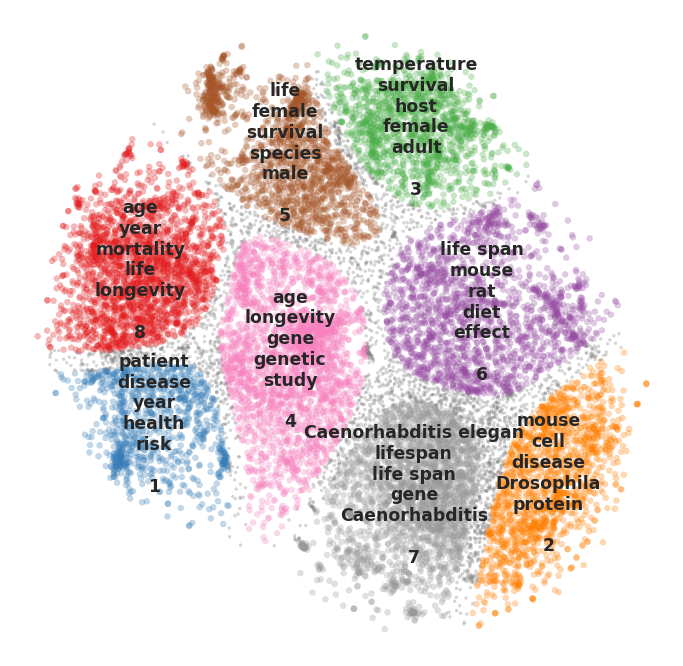

In [10]:
yake_desc = create_plot(yake_keywords, title='YAKE!-hyper', label_method=hypergeom_clusters)
# plt.savefig('document-map-yake-hyper.jpg', dpi=300)

## Visulaisation with Transformers keyowrds

In [11]:
%%time

from bert_keyword_extractor import TransformerKeywordExtractor

def lemmatize_ph(phrase):
    return " ".join(lemmatizer.lemmatize(w) for w in phrase.split())

def get_kws(model_path):
    extractor = TransformerKeywordExtractor(model_path)
    bert_keywords = extractor.extract_keywords(df['abstract'])
    del extractor
    return [[lemmatize_ph(w) for w, _ in kws] for kws in bert_keywords]
        
crosloengual_keywords = get_kws('models/crosloeng')

Token indices sequence length is longer than the specified maximum sequence length for this model (724 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/19 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 18110
  Batch size = 8


/home/primoz/text-semantics/examples/bert_keyword_extractor.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(predictions).to(self.device), dim=2)


CPU times: user 4min 32s, sys: 4min 59s, total: 9min 31s
Wall time: 8min 52s


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 12
1 56
2 84
3 13
4 56
5 63
6 66
7 70


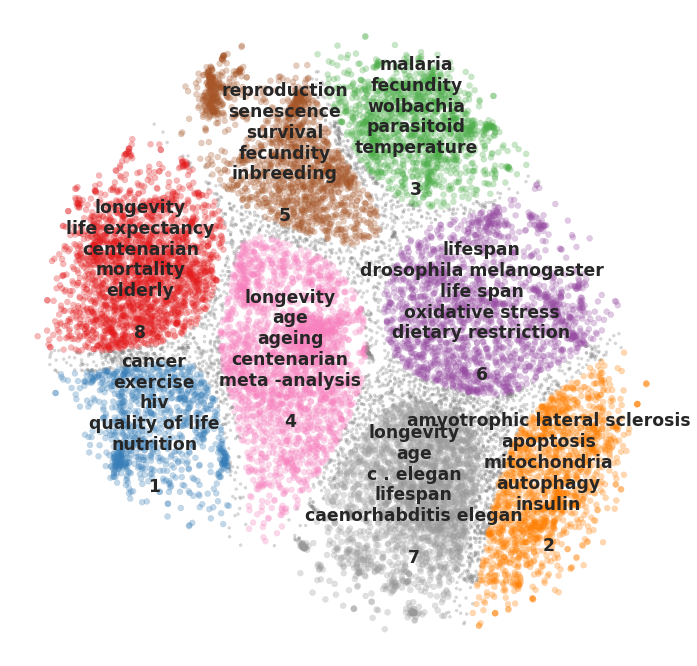

In [12]:
bert_desc = create_plot(crosloengual_keywords, title='BERT-hyper', label_method=hypergeom_clusters)

In [14]:
crosloengual_keywords[:30]

[['longevity', 'self -care'],
 ['carbamide', 'in -office bleach'],
 ['pollen', 'pristine ®,', 'pristine ®', 'pristine ®.'],
 ['mitochondria', 'age', 'cellular senescence'],
 ['longevity'],
 ['longevity', 'elderly', 'longevity'],
 ['svip', 'vcp', 'valosin -contain'],
 ['casein -maltodextrin-pa', 'casein -maltodextrin'],
 ['age', 'senescence', 'reproduction'],
 ['sul -2,', 'longevity', 'age', 'sul -2'],
 ['stress', 'spodoptera litura'],
 ['ro', 'dehp', 'longevity', 'rna', 'foxo', 'cerna', 'mehp', 'rna sequence'],
 ['cognitive impairment', 'cognition impairment', 'blood lead', 'longevity'],
 ['oxygen saturation', 'all -cause mortality'],
 ['cognitive impairment', 'longevity', 'uric acid', 'china'],
 ['longevity', 'depressive symptom', 'depression symptom'],
 ['hypertriglyceridemia', 'china', 'oxidative stress'],
 ['hyperuricemia', 'arsenic', 'longevity', 'blood arsenic', 'uric acid'],
 ['dock', 'stress', 'c . elegan', 'dopamine', 'ursolic acid (ua)'],
 ['centenarian rate', 'mortality rate

In [21]:
df["abstract"].iloc[18]

'Depression and stress-related disorders are leading causes of death worldwide. Standard treatments elevating serotonin or noradrenaline levels are not sufficiently effective and cause adverse side effects. A connection between dopamine pathways and stress-related disorders has been suggested. Compounds derived from herbal medicine could be a promising alternative. We examined the neuroprotective effects of ursolic acid (UA) by focusing on dopamine signalling.\nTrolox equivalent capacity assay was used to determine the antioxidant activities of UA in vitro. C. elegans N2 wildtype and dopamine receptor-knockout mutants (dop1-deficient RB665 and dop3-deficient LX703 strains) were used as in vivo models. H2DCFDA and acute juglone assays were applied to determine the antioxidant activity in dependency of dopamine pathways in vivo. Stress was assessed by heat and acute osmotic stress assays. The influence of UA on overall survival was analyzed by a life span assay. The dop1 and dop3 mRNA ex